In [1]:
!pip install segmentation-models-pytorch

In [2]:
!pip install matplotlib

In [3]:
import os
os.environ[ 'CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir
import albumentations as albu

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1m0bc3ti
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1m0bc3ti


In [5]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
import matplotlib.pyplot as plt
import torch.nn as nn

In [6]:
DATA_DIR = '/gdrive/MyDrive/Henry_Lab/Cap08102020_seg/'
SAVE_DIR = '/playpen1/qiuyang/refined_segmentation/models/'
FINETUNE2_DIR = '/playpen1/qiuyang/refined_segmentation/models/final/'
# x_train_dir  = os.path.join(DATA_DIR, 'train')
# y_train_dir = os.path.join(DATA_DIR, 'trainannot')
# x_valid_dir = os.path.join(DATA_DIR, 'val')
# y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_smalltrain_dir = '/playpen1/qiuyang/refined_segmentation/pascal_image_1'
y_smalltrain_dir = '/playpen1/qiuyang/refined_segmentation/pascal_mask_1'
x_finetune_dir = '/playpen1/qiuyang/refined_segmentation/pascal_image_50'
y_finetune_dir = '/playpen1/qiuyang/refined_segmentation/refined_mask_50'

x_test_dir = '/playpen1/qiuyang/refined_segmentation/pascal_test_image_20'
y_test_dir = '/playpen1/qiuyang/refined_segmentation/refined_test_mask_20'
x_unannotated_dir = '/playpen1/qiuyang/refined_segmentation/unannotated_image_4'
y_unannotated_dir = '/playpen1/qiuyang/refined_segmentation/unannotated_image_4'
# x_finetune2_dir = '/playpen1/qiuyang/refined_segmentation/pascal_finetune2_image_4'
# y_finetune2_dir = '/playpen1/qiuyang/refined_segmentation/pascal_finetune2_mask_4'

In [7]:
!pip install ninja

In [8]:
cd /playpen1/qiuyang/Self-Correction-Human-Parsing


/playpen1/qiuyang/Self-Correction-Human-Parsing


In [9]:
import networks

In [10]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()
    
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.01, rotate_limit=10, shift_limit=0.0625, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=512, min_width=512, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.Resize(height=512, width=512)
        #albu.RandomResizedCrop(height=512, width=512, scale=(0.8, 0.8))
    ]
    return albu.Compose(train_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def to_image_scale(x, **kwargs):
    x = x.astype(np.float32)
    x = x /255.0
    x = x - 0.5
    x = x * 2
    return x
def to_mask_scale(x, **kwargs):
    x  = x.astype(np.float32)
    x = x/255.0
    return x
def get_transposed():
    _transform = [
      albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)
def get_preprocessing():
    _transform = [
      albu.Lambda(image=to_image_scale, mask=to_mask_scale),
      albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


In [11]:
def forward(pretrained_model, input, input_size):
  output = pretrained_model(input)
  upsample = torch.nn.Upsample(size=input_size, mode='bilinear', align_corners=True)
  upsample_output = upsample(output[0][-1])
  logit0 = upsample_output[:, 0, :, :]
  logit1,_ = torch.max(upsample_output[:, 1:, :, :], 1)
  logit = torch.stack((logit0, logit1), 1)
  return logit

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3216.JPG


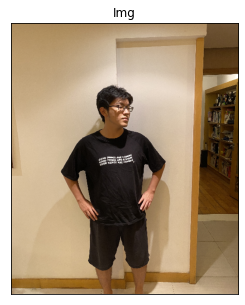

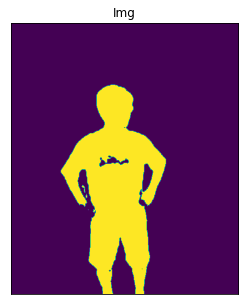

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3217.JPG


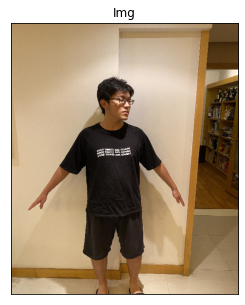

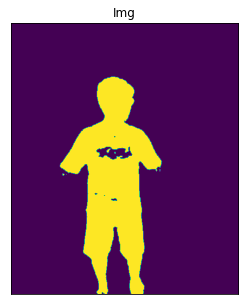

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3218.JPG


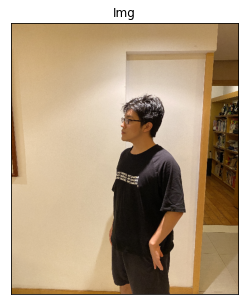

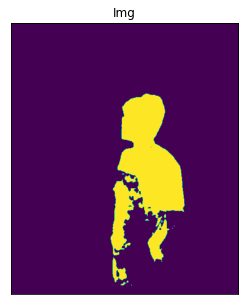

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3219.JPG


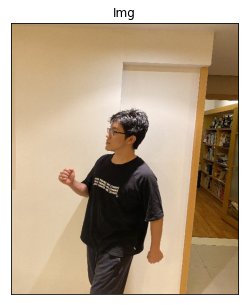

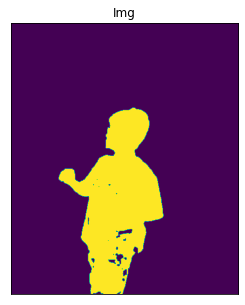

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3220.JPG


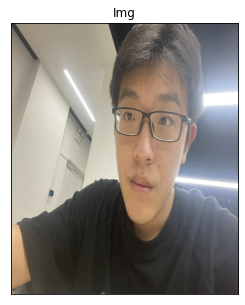

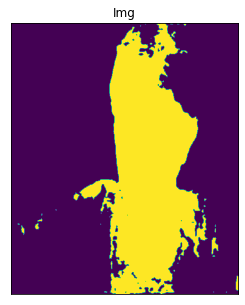

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3221.JPG


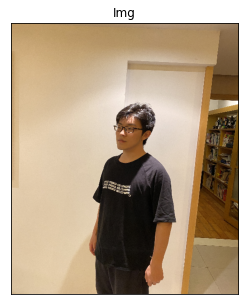

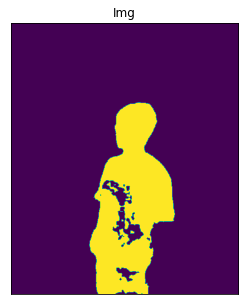

/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_3222.JPG


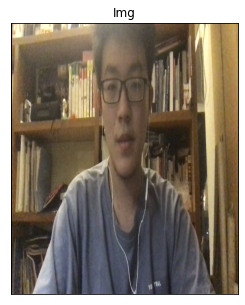

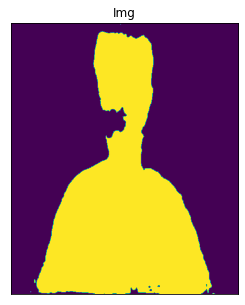

In [15]:
# July 20 Generate selfie masks
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
output_size = [612, 512]
# load  model
loaded_model = torch.load(os.path.join(SAVE_DIR, 'best_model018.pth'))
# loaded_model = torch.load(os.path.join(FINETUNE2_DIR, 'best_model.pth'))
loaded_model.eval() 

# set up save dir
fn2 = r'/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_%04d.JPG'
fn3 = r'/playpen1/qiuyang/refined_segmentation/July_20_selfie/IMG_%04d.png'
fn4 = r'/playpen1/qiuyang/refined_segmentation/July_20_selfie/MASK_%04d.png'
for fid in range(3216, 3223):
    print(fn2%fid)
    image = cv2.imread(fn2%fid)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resize = albu.Compose([albu.Resize(height=612, width=512)])
    sample = resize(image=image)
    image = sample['image']
    visualize(img=image)
    cv2.imwrite(fn3%fid, image)
    preprocessing = get_preprocessing()
    sample = preprocessing(image=image)
    image = sample['image']
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    pr_mask = forward(loaded_model, x_tensor, output_size)
    pred = pr_mask.softmax(dim=1).argmax(dim=1).squeeze(0).cpu().detach().numpy()
    mask = pred * 255
    visualize(
        img=mask
    )
    cv2.imwrite(fn4%fid, mask)